In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna

In [18]:
from preprocessing import *
data_path = "data/game.csv"
X_train, X_test, y_train, y_test = prep_all(data_path)

X_train = X_train.values.reshape(-1, 1, 135)  # Reshape to (32520, 1, 136)
X_test = X_test.values.reshape(-1, 1, 135)    # Reshape to (N, 1, 136), where N is the number of test samples

train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train.to_numpy()))
test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test.to_numpy()))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(test_data, batch_size=64, shuffle=False)

/Users/spencer/Desktop/Repos/nba-predictor/preprocessing.py:43: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['matchup', 'team_abbreviation', 'team_name', 'wl'], dtype='object')
  rolling_averages = grouped[columns_to_average].apply(lambda x: x.rolling(window=len(x), min_periods=1).mean().shift(1))
/Users/spencer/Desktop/Repos/nba-predictor/preprocessing.py:43: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  rolling_averages = grouped[columns_to_average].apply(lambda x: x.rolling

In [19]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out


In [20]:
input_size = X_train.shape[2]  # The number of features in your preprocessed data
output_size = 2  # Win or loss (binary classification)

model = LogisticRegressionModel(input_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [21]:
num_epochs = 50
losses= []
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.squeeze(1).float(), labels.long()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/50], Loss: 0.6258
Epoch [2/50], Loss: 0.5996
Epoch [3/50], Loss: 0.7050
Epoch [4/50], Loss: 0.6491
Epoch [5/50], Loss: 0.5758
Epoch [6/50], Loss: 0.6083
Epoch [7/50], Loss: 0.5908
Epoch [8/50], Loss: 0.5392
Epoch [9/50], Loss: 0.6307
Epoch [10/50], Loss: 0.6249
Epoch [11/50], Loss: 0.6094
Epoch [12/50], Loss: 0.5324
Epoch [13/50], Loss: 0.5722
Epoch [14/50], Loss: 0.7274
Epoch [15/50], Loss: 0.6108
Epoch [16/50], Loss: 0.6652
Epoch [17/50], Loss: 0.5908
Epoch [18/50], Loss: 0.6253
Epoch [19/50], Loss: 0.6164
Epoch [20/50], Loss: 0.6331
Epoch [21/50], Loss: 0.5424
Epoch [22/50], Loss: 0.6003
Epoch [23/50], Loss: 0.5497
Epoch [24/50], Loss: 0.6162
Epoch [25/50], Loss: 0.5677
Epoch [26/50], Loss: 0.6333
Epoch [27/50], Loss: 0.5898
Epoch [28/50], Loss: 0.5482
Epoch [29/50], Loss: 0.5645
Epoch [30/50], Loss: 0.6306
Epoch [31/50], Loss: 0.5678
Epoch [32/50], Loss: 0.5733
Epoch [33/50], Loss: 0.6471
Epoch [34/50], Loss: 0.6981
Epoch [35/50], Loss: 0.5436
Epoch [36/50], Loss: 0.5949
E

In [22]:
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in valid_loader:
        inputs, labels = inputs.squeeze(1).float(), labels.long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 66.38%


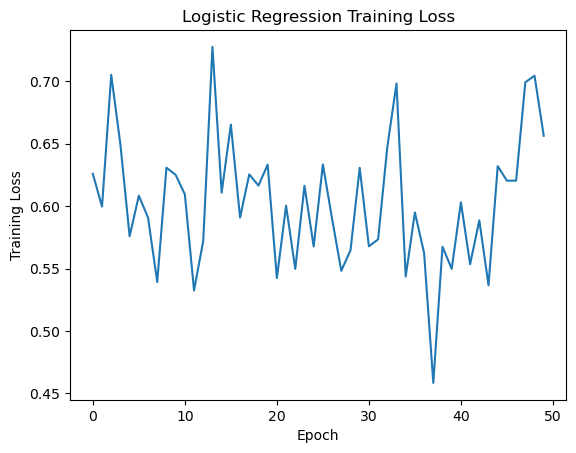

In [23]:
# Plot the loss function
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Logistic Regression Training Loss')
plt.savefig('plots/results/logisticregression.png')


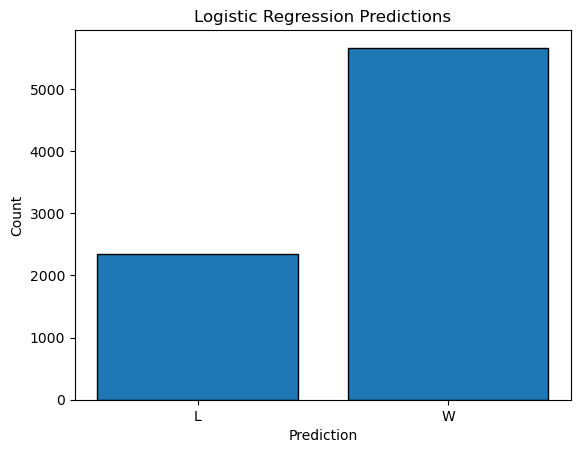

In [24]:
# Histogram of predictions
with torch.no_grad():
    predictions = []
    for inputs, labels in valid_loader:
        inputs, labels = inputs.squeeze(1).float(), labels.long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions += predicted.tolist()

    plt.hist(predictions, bins=[0, 1, 2], align='left', rwidth=0.8, edgecolor='black')
    plt.xlabel('Prediction')
    plt.ylabel('Count')
    plt.title('Logistic Regression Predictions')
    plt.xticks([0, 1], ['L', 'W'])
    plt.savefig('plots/results/logisticregression_hist.png')


In [25]:
input_size = X_train.shape[2]  # The number of features in your preprocessed data
output_size = 2  # Win or loss (binary classification)

model = LogisticRegressionModel(input_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [26]:
num_epochs = 50
losses= []
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.squeeze(1).float(), labels.long()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 0.5109
Epoch [2/50], Loss: 0.6036
Epoch [3/50], Loss: 0.5803
Epoch [4/50], Loss: 0.5885
Epoch [5/50], Loss: 0.6305
Epoch [6/50], Loss: 0.7772
Epoch [7/50], Loss: 0.6503
Epoch [8/50], Loss: 0.5214
Epoch [9/50], Loss: 0.5650
Epoch [10/50], Loss: 0.8144
Epoch [11/50], Loss: 0.6053
Epoch [12/50], Loss: 0.6386
Epoch [13/50], Loss: 0.6457
Epoch [14/50], Loss: 0.5674
Epoch [15/50], Loss: 0.6084
Epoch [16/50], Loss: 0.5259
Epoch [17/50], Loss: 0.6787
Epoch [18/50], Loss: 0.6379
Epoch [19/50], Loss: 0.6375
Epoch [20/50], Loss: 0.7340
Epoch [21/50], Loss: 0.6497
Epoch [22/50], Loss: 0.5944
Epoch [23/50], Loss: 0.6184
Epoch [24/50], Loss: 0.5444
Epoch [25/50], Loss: 0.6497
Epoch [26/50], Loss: 0.5411
Epoch [27/50], Loss: 0.7547
Epoch [28/50], Loss: 0.5513
Epoch [29/50], Loss: 0.5988
Epoch [30/50], Loss: 0.6243
Epoch [31/50], Loss: 0.5708
Epoch [32/50], Loss: 0.6381
Epoch [33/50], Loss: 0.5553
Epoch [34/50], Loss: 0.5890
Epoch [35/50], Loss: 0.7187
Epoch [36/50], Loss: 0.6079
E

In [27]:
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in valid_loader:
        inputs, labels = inputs.squeeze(1).float(), labels.long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 65.85%
